In [1]:
import rootutils
import random
import pickle
import numpy as np
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import torch
from torchvision.ops import box_convert
path = '/idiap/temp/pvuillecard/projects/gaze_pretrain/'
rootutils.setup_root(path, indicator=".project-root", pythonpath=True)


PosixPath('/remote/idiap.svm/temp.perception01/pvuillecard/projects/gaze_pretrain')

In [4]:
with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gaze360/gaze360_image_database.pkl', 'rb') as f:
    image_db_gaze360 = pickle.load(f)

splits = pd.read_csv('/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gaze360/samples/image_samples.csv')
# transform to dict 

splits = splits.set_index("image_id")
splits = splits.to_dict(orient="index")

# include the face information in the prediction 
for k in image_db_gaze360.keys():
    face_info = image_db_gaze360[k]['other']['person_face_bbox']
    is_face = face_info[0] != -1
    image_db_gaze360[k]['face_info'] = 1 if is_face else 0
    gaze_dir = image_db_gaze360[k]['other']['gaze_dir']
    # compute the angular error with center (0,0,-1)
    angular_error = np.arccos(np.dot(gaze_dir, np.array([0, 0, -1])) / (np.linalg.norm(gaze_dir) * np.linalg.norm(np.array([0, 0, -1]))))*180/np.pi
    image_db_gaze360[k]['angular_error'] = angular_error
    try :
        image_db_gaze360[k]['split'] = splits[k]['split']
    except:
        image_db_gaze360[k]['split'] = None

Text(0, 0.5, 'Number of samples')

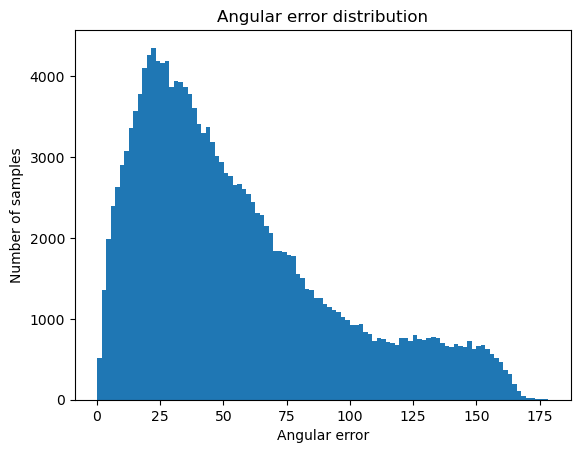

In [6]:
# plot histogram of angular error
angular_errors = [image_db_gaze360[k]['angular_error'] for k in image_db_gaze360.keys() if image_db_gaze360[k]['split'] is not None]
plt.hist(angular_errors, bins=100)
plt.title('Angular error distribution')
plt.xlabel('Angular error')
plt.ylabel('Number of samples')


In [8]:
print('train samples:', len([k for k in image_db_gaze360.keys() if image_db_gaze360[k]['split'] == 'train']))
print('validation samples:', len([k for k in image_db_gaze360.keys() if image_db_gaze360[k]['split'] == 'validation']))
print('test samples:', len([k for k in image_db_gaze360.keys() if image_db_gaze360[k]['split'] == 'test']))

print('total number of samples:', len(image_db_gaze360))
print('samples with face:', len([k for k in image_db_gaze360.keys() if image_db_gaze360[k]['face_info'] == 1 and image_db_gaze360[k]['split'] is not None]))
print('samples without face:', len([k for k in image_db_gaze360.keys() if image_db_gaze360[k]['face_info'] == 0 and image_db_gaze360[k]['split'] is not None]))
print('samples with angular error <= 90:', len([k for k in image_db_gaze360.keys() if image_db_gaze360[k]['angular_error'] <= 90 and image_db_gaze360[k]['split'] is not None]))
print('samples with angular error > 90:', len([k for k in image_db_gaze360.keys() if image_db_gaze360[k]['angular_error'] > 90 and image_db_gaze360[k]['split'] is not None]))
print('samples with angular error <= 20:', len([k for k in image_db_gaze360.keys() if image_db_gaze360[k]['angular_error'] <= 20 and image_db_gaze360[k]['split'] is not None]))
print('sample with face and >90',len([k for k in image_db_gaze360.keys() if image_db_gaze360[k]['face_info'] == 1 and image_db_gaze360[k]['angular_error'] > 90 and image_db_gaze360[k]['split'] is not None]))

train samples: 126928
validation samples: 17038
test samples: 25969
total number of samples: 197588
samples with face: 112251
samples without face: 57684
samples with angular error <= 90: 138260
samples with angular error > 90: 31675
samples with angular error <= 20: 30194
sample with face and >90 1330


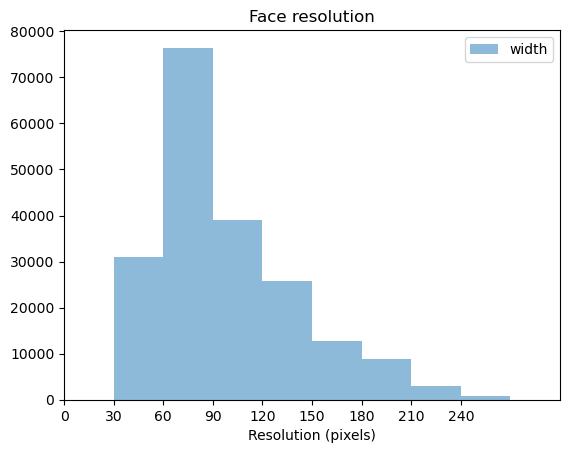

In [7]:
def hist_face_resolution(image_db):
    res = []
    for key in image_db.keys():
        
        res.append(image_db[key]['other']['head_bbox_yolo'][2]-image_db[key]['other']['head_bbox_yolo'][0])
    res = np.array(res)
    plt.hist(res, bins=[0,30,60,90,120,150,180,210,240,270], alpha=0.5, label='width')
    plt.xlim([0, 300])
    plt.xticks(np.arange(0, 270, 30))
    plt.legend(loc='upper right')
    plt.title('Face resolution')
    plt.xlabel('Resolution (pixels)')
    plt.show()

hist_face_resolution(image_db_gaze360)

In [8]:
# print on sample 
keys = list(image_db_gaze360.keys())
k = random.choice(keys)

for k,v in image_db_gaze360[k].items():
    print(k,v)
    print('------------------------')


image_path /idiap/resource/database/Gaze360/imgs/rec_039/body/000658/000038.jpg
------------------------
clip_path /idiap/resource/database/Gaze360/imgs/rec_039/body/000658
------------------------
frame 38
------------------------
clip_name rec_039_000658
------------------------
clip_id clip_00000432
------------------------
other {'head_bbox': array([1635, 2067, 1752, 2185]), 'body_bbox': array([1609, 2018, 1796, 2645]), 'person_eye_right_bbox': array([1671, 2120, 1677, 2127]), 'person_eye_left_bbox': array([1684, 2118, 1694, 2128]), 'person_face_bbox': array([1661, 2104, 1705, 2148]), 'gaze_dir': array([ 0.76733351, -0.44465319, -0.46204202]), 'split': 0, 'head_bbox_in_body_bbox': array([ 25,  49, 142, 166]), 'image_og_height_width': array([3382, 4096]), 'head_bbox_yolo': [1669, 2087, 1728, 2158], 'head_bbox_yolo_in_body_bbox': [60, 69, 119, 140], 'head_bbox_crop_in_body_bbox': array([ 18,  33, 160, 175]), 'head_bbox_crop': [1627, 2051, 1769, 2193]}
------------------------
image_w

In [13]:
L = []

for k in image_db_gaze360.keys():
    angular_error = image_db_gaze360[k]['angular_error']
    bbox_yolo = image_db_gaze360[k]['other']['head_bbox_yolo']
    bbox_og = image_db_gaze360[k]['other']['head_bbox']
    
    width_yolo = max(bbox_yolo[2] - bbox_yolo[0], bbox_yolo[3] - bbox_yolo[1])*1.1

    width_og = bbox_og[2] - bbox_og[0]
    L.append( [angular_error, width_yolo, width_og, image_db_gaze360[k]['face_info']] )

bbox_info = pd.DataFrame(L, columns=['angular_error', 'width_yolo', 'width_og', 'face_info'])
bbox_info['diff_width'] = bbox_info['width_yolo'] - bbox_info['width_og']

Text(0.5, 0, 'Difference')

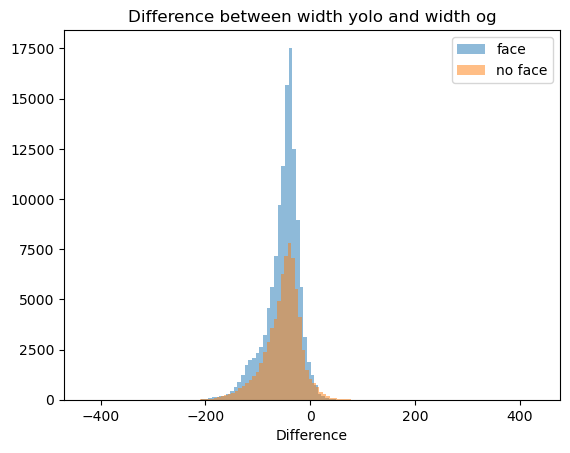

In [14]:
# plot distribution of diff_width for face and no face
bbox_info_face = bbox_info[bbox_info['face_info'] == 1]
bbox_info_no_face = bbox_info[bbox_info['face_info'] == 0]
plt.hist(bbox_info_face['diff_width'], bins=100, alpha=0.5, label='face')
plt.hist(bbox_info_no_face['diff_width'], bins=100, alpha=0.5, label='no face')
plt.legend(loc='upper right')
plt.title('Difference between width yolo and width og')
plt.xlabel('Difference')

Text(0, 0.5, 'Diff width')

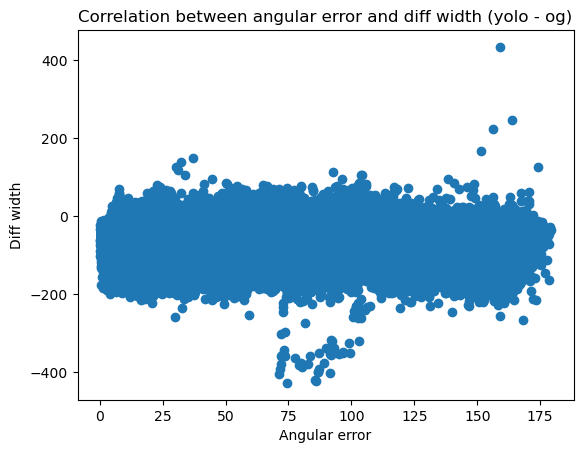

In [63]:
# plot correlation between angular error and diff width 
plt.scatter(bbox_info['angular_error'], bbox_info['diff_width'])
plt.title('Correlation between angular error and diff width (yolo - og)')
plt.xlabel('Angular error')
plt.ylabel('Diff width')


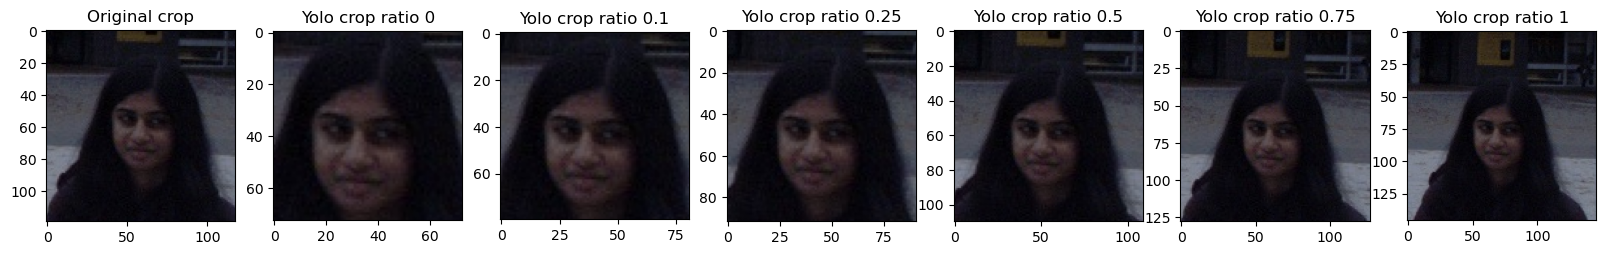

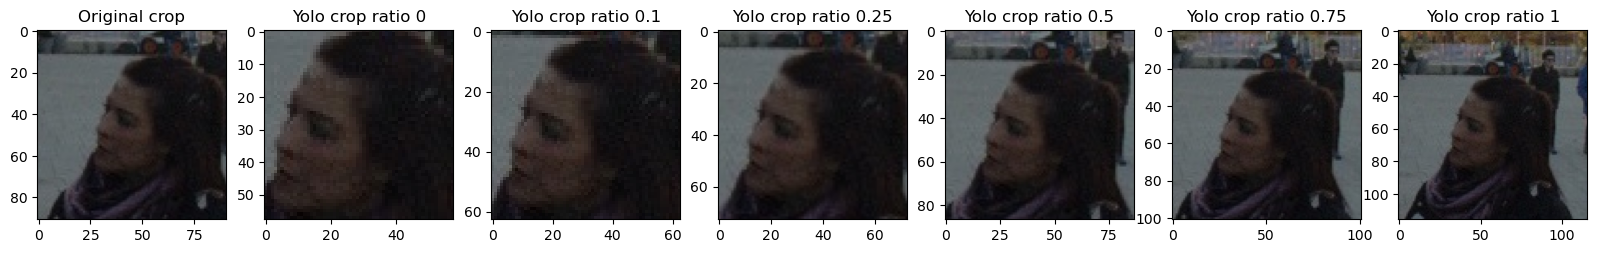

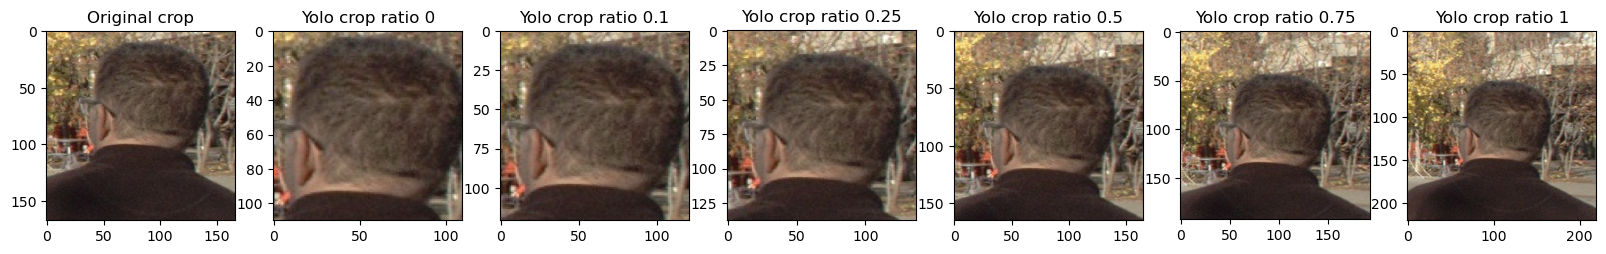

In [78]:
# plot images from the actual crop vs the yolo crop


def plot_image(image_db, key):
    img = cv2.imread(image_db[key]['image_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_2 = cv2.imread(image_db[key]['image_path'].replace('body', 'head'))
    img_yolo = []
    for ratio in [0,0.1,0.25,0.5,0.75,1]:
        bbox_yolo = [image_db[key]['other']['head_bbox_yolo_in_body_bbox']]
        bbox = torch.tensor(np.array(bbox_yolo))
        bbox_cxcywh = box_convert(bbox, in_fmt="xyxy", out_fmt="cxcywh")
        sizes = torch.max(bbox_cxcywh[:, 2:], 1)[0]
        sizes = torch.stack([sizes, sizes], 1)
        bbox_cxcywh[:, 2:] = sizes + (sizes * ratio)
        bbox_yolo = box_convert(bbox_cxcywh, in_fmt="cxcywh", out_fmt="xyxy")[0].numpy().astype(int)
        img_yolo.append(img[bbox_yolo[1]:bbox_yolo[3], bbox_yolo[0]:bbox_yolo[2]] )
    bbox_og = image_db[key]['other']['head_bbox_in_body_bbox']
    
    img_og = img[bbox_og[1]:bbox_og[3], bbox_og[0]:bbox_og[2]]
    plt.figure(figsize=(20,10))
    plt.subplot(1,7,1)
    plt.imshow(img_og)
    plt.title('Original crop')
    for i , ratio in enumerate([0,0.1,0.25,0.5,0.75,1]):
        plt.subplot(1,7,i+2)
        plt.imshow(img_yolo[i])
        plt.title('Yolo crop ratio {}'.format(ratio))

    
    plt.show()

k = random.choice(keys)
plot_image(image_db_gaze360, k)
k = random.choice(keys)
plot_image(image_db_gaze360, k)
k = random.choice(keys)
plot_image(image_db_gaze360, k)